In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import functional as F
import math

torch.manual_seed(42)
if torch.cuda.is_available():
  torch.cuda.manual_seed(42)

device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
import warnings
warnings.filterwarnings("ignore")
import tiktoken
enc = tiktoken.get_encoding("gpt2")
device

device(type='cuda')

In [2]:
from dataclasses import dataclass

@dataclass
class ChatGPT2Config:
    block_size: int = 8
    vocab_size: int = enc.n_vocab
    n_layers: int = 6
    d_model: int = 64
    n_heads: int = 4  # 64/4 = 16D per head
    batch_size: int = 4



class CasualSelfAttetnion(nn.Module):
  def __init__(self,config):
    super().__init__()
    assert config.d_model % config.n_heads ==0 ,"Head is not divisible by embedding dimesnion chose differnt head value"
    self.c_att = nn.Linear(config.d_model,3*config.d_model) # Query key and value vector projection for all heads
    self.c_proj = nn.Linear(config.d_model,config.d_model) # output projection for q,k,v
    self.n_heads = config.n_heads  # no of heads
    self.d_model = config.d_model # embedding dimesnion
    # this create masked once during initlization more effiecnet compare to creating maske on every forward pass
    self.register_buffer("bias",torch.tril(torch.ones(config.block_size,config.block_size))
                        .view(1,1,config.block_size,config.block_size))  #equailvent to (B,n_head,T,T)

  def forward(self,x,flash_attention=False):
    B,T,C = x.shape

    qkv = self.c_att(x)  # generate q ,k and value vector   qkv.shape = (B, T, 3 * C)
    # torch.Tensor.split(split_size, dim)
    q,k,v = qkv.split(self.d_model,dim=2)
    # d_head = d_model(C) // n_heads
    k = k.view(B,T,self.n_heads,C//self.n_heads).transpose(1,2) # (B,T,C) ===> (B,T,n_head,d_head) ===> (B,n_head,T,d_head)
    q = q.view(B,T,self.n_heads,C//self.n_heads).transpose(1,2) # (B,T,C) ===> (B,T,n_head,d_head) ===> (B,n_head,T,d_head)
    v = v.view(B,T,self.n_heads,C//self.n_heads).transpose(1,2) # (B,T,C) ===> (B,T,n_head,d_head) ===> (B,n_head,T,d_head)


    # FLASH ATTETNION:
    if flash_attention:
      y = torch.nn.functional.scaled_dot_product_attention(
          q,k,v,
          attn_mask=None,  # for padding masking(encoder)
          dropout_p=0.1,
          is_causal=True  # for masking(autoregressive)
          ) # ==> (B, n_head, T, d_head)

    else:
      # attetnion score
      att = q @ k.transpose(-2,-1) * (1.0/math.sqrt(k.size(-1)))  #dimesnion of key vector

      # mask attetnion ==> token attetnd to only previous token and not the future tokens
      att = att.masked_fill(self.bias[:,:,:T,:T]==0,float('-inf'))  #(B,n_head,T,T)

      att = F.softmax(att,dim=-1)

      #attetnion weight
      y = att @ v  #(B,n_head,T,T) x (B,n_head,T,d_head) ===> (B,n_head,T,d_head)


    # re-assemble all head output side by side
    # C = H * head_dim
    y = y.transpose(1,2).contiguous().view(B,T,C) # (B,H,T,h_dim) ==> (B,T,H,d_head)  ===> (B,T,C)

    #output projection
    y = self.c_proj(y)

    return y


class MLP(nn.Module):
  def __init__(self,config):
    super().__init__()
    self.c_fc = nn.Linear(config.d_model,4*config.d_model)
    self.gelu = nn.GELU(approximate="tanh")
    self.c_proj = nn.Linear(4*config.d_model,config.d_model)

  def forward(self,x):
    x = self.c_fc(x)
    x = self.gelu(x)
    x = self.c_proj(x)
    return x


class Block(nn.Module):
  """Single Block Of Transformer"""
  def __init__(self,config):
    super().__init__()
    self.ln1 = nn.LayerNorm(config.d_model)
    self.att = CasualSelfAttetnion(config)
    self.ln2 = nn.LayerNorm(config.d_model)
    self.mlp = MLP(config)

  def forward(self,x):
    x = x + self.att(self.ln1(x),flash_attention=True)
    x = x + self.mlp(self.ln2(x))
    return x

In [ ]:
class GPT(nn.Module):

  def __init__(self,config):
    super().__init__()
    self.config = config

    self.transformers = nn.ModuleDict({
        "wte":nn.Embedding(config.vocab_size,config.d_model), #Token embedding
        "wpe": nn.Embedding(config.block_size,config.d_model), # posional embedding
        "h" :nn.ModuleList([Block(config) for _ in range (config.n_layers)]), # Head in each self attenion block
        "ln_f": nn.LayerNorm(config.d_model)
    })

    self.lm_head = nn.Linear(config.d_model,config.vocab_size,bias=False) # final head projection layer

    #  In GPT the same weight matrix is used for both word embedding and final output layer.
    # Weight tying (share token embedding weights with output head)  save computatuion heavily
    self.lm_head.weight = self.transformers["wte"].weight

    #init param
    self.apply(self._init_weights)


  def _init_weights(self,module):
    if isinstance(module,nn.Linear): #apply to linear layers
      torch.nn.init.normal_(module.weight,mean=0.0,std=0.02) #init weight using normal and mean 0 std 0.02
      if module.bias is  not None:
        torch.nn.init.zeros_(module.bias)
    elif isinstance(module,nn.Embedding):
      torch.nn.init.normal_(module.weight,mean=0.0,std=0.02)  # apply to embedding


  def forward(self,x,target=None):
    B,T = x.shape

    pos = torch.arange(0,T,dtype=torch.long,device=device)  # (T)
    pose_emb = self.transformers["wpe"](pos)  # psotional emebdiing  (T,d_model)
    tok_emb = self.transformers["wte"](x)  # token embedding  (B,T,d_model)
    x = tok_emb + pose_emb  # token + pos embeddinf merge

    for block in self.transformers.h:
      x = block(x)

    x = self.transformers["ln_f"](x)

    # Get logit after final transformer block
    logits = self.lm_head(x)   #(B,T,vocab_size )

    loss = None
    if target is not None:
      B,T,C = logits.shape  #(B,T,C)  cross entorpy ==> accept (B,C)
      logits = logits.view(B*T,C)
      target = target.view(B*T)
      loss = F.cross_entropy(logits,target)
    return logits,loss



In [15]:
with open("input.txt","r") as f:
  text = f.read()
enc = tiktoken.get_encoding("gpt2")

n = int(0.9 * len(text))
train = text[:n]
val = text[n:]


class DataLoaderLite:
  def __init__(self,B,T,data):
    self.B=B
    self.T=T
    tokens_list = enc.encode(data)
    self.tokens = torch.tensor(tokens_list,dtype=torch.long)
    self.current_position = 0  # curret token position

  def next_batch(self):
    B, T = self.B, self.T

    # Check if we have enough tokens left, if not, wrap around
    if self.current_position + (B*T + 1) > len(self.tokens):
      self.current_position = 0

    buf = self.tokens[self.current_position:self.current_position + B*T + 1]

    # Safety check: ensure we have enough tokens
    if len(buf) < B*T + 1:
      raise ValueError(f"Not enough tokens! Need {B*T+1}, got {len(buf)}")

    x = buf[:-1].view(B, T)  # inputs
    y = buf[1:].view(B, T)   # targets

    # Move pointer ahead
    self.current_position += B * T

    x, y = x.to(device), y.to(device)
    return x, y


  def reset(self):
    """Reset the data loader to the beginning"""
    self.current_position = 0

config = ChatGPT2Config()

train_loader = DataLoaderLite(config.batch_size,config.block_size,data=train)
val_loader = DataLoaderLite(config.batch_size,config.block_size,data=val)

# PERCISION  ==> how exact your numbers are in GPU computations.
# High precision	  1.234567	Exact
# Medium precision	1.2345	  Rounded a little
# Low precision	    1.23	    Rounded a lot

# default is highest(float32) ==> high(tensorfloat32)
# "highest"  ==> FP32   # Full precision(fp32) (slowest, most accurate)
# "high"     ==> TF32   # TensorFloat32 (fast, slightly less accurate)
# "medium"   ==> FP16 / BF16 mixed  # Fastest, lowest precision
torch.set_float32_matmul_precision("high")

In [16]:
import torch

print("TF32 enabled:", torch.backends.cuda.matmul.allow_tf32)
print("BF16 supported:", torch.cuda.is_bf16_supported())
print("FP16 supported:", torch.cuda.is_available())

#to enable manually
# torch.backends.cuda.matmul.allow_tf32 = True
# torch.backends.cudnn.allow_tf32 = True



TF32 enabled: True
BF16 supported: True
FP16 supported: True


✅ autocast: speeds up by using FP16.

✅ matmul_precision("high"): keeps matmuls stable and accurate

# without weight tying and weight initlizer


In [ ]:
model = GPT(config =ChatGPT2Config()).to(device)
learning_rate=1e-4
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

for i in range(10):
  x,y = train_loader.next_batch()
  optimizer.zero_grad()
  logits,loss = model(x,y)
  loss.backward()
  optimizer.step()
  print(f"step {i+1} and loss is {loss.item()}")

step 1 and loss is 11.106304168701172
step 2 and loss is 10.977777481079102
step 3 and loss is 11.124197006225586
step 4 and loss is 10.965313911437988
step 5 and loss is 11.12607192993164
step 6 and loss is 10.848352432250977
step 7 and loss is 10.950014114379883
step 8 and loss is 11.060933113098145
step 9 and loss is 10.99557876586914
step 10 and loss is 11.091280937194824


# With weight initlizer and weight tying


In [ ]:
model = GPT(config =ChatGPT2Config(vocab_size=50304)).to(device) # as 50304 is good no 2 power n
# fusing small operation in single large one so it doesnt use many gpu kernel
# it can make traing slow in start but later fast
model = torch.compile(model) # reduce python overhead
learning_rate=1e-4
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scaler = torch.cuda.amp.GradScaler() # for stable FP16 training(amp=automatic mixed percisoin)


import time
s = time.time()
for i in range(10):
  t0 = time.time()
  x,y = train_loader.next_batch()
  optimizer.zero_grad()

  if device == "cuda":
  # forward pass with autocast(mixed precision beacuse some weights are in lower percesion and some are in higher precision)
    with torch.cuda.amp.autocast(device_type=device,dtype=torch.float16):
      logits,loss = model(x,y)
  else:
    logits,loss = model(x,y)
  scaler.scale(loss).backward()

  optimizer.step()
  t1 = time.time()
  time_per_epoch = t1-t0
  token_per_sec = (train_loader.B * train_loader.T)/(t1-t0)
  print(f"step {i+1} =>   |  loss {loss.item()}  |  time_per_epoch {time_per_epoch:.2f}s  |  toke/sec {token_per_sec:.2f}")

e = time.time()
end = e-s
print(f"Total time : {end}")

 20%|██        | 2/10 [00:00<00:00, 10.89it/s]

step 1 and loss is 10.824481010437012 time_per_epoch 0.10ms, toke/sec 326.16
step 2 and loss is 10.792647361755371 time_per_epoch 0.08ms, toke/sec 376.88
step 3 and loss is 10.758214950561523 time_per_epoch 0.10ms, toke/sec 327.46


 60%|██████    | 6/10 [00:00<00:00, 11.57it/s]

step 4 and loss is 10.783865928649902 time_per_epoch 0.07ms, toke/sec 448.82
step 5 and loss is 10.824305534362793 time_per_epoch 0.09ms, toke/sec 374.71
step 6 and loss is 10.825878143310547 time_per_epoch 0.08ms, toke/sec 385.34


 80%|████████  | 8/10 [00:00<00:00, 10.92it/s]

step 7 and loss is 10.7822265625 time_per_epoch 0.11ms, toke/sec 301.41
step 8 and loss is 10.787862777709961 time_per_epoch 0.09ms, toke/sec 351.19
step 9 and loss is 10.746721267700195 time_per_epoch 0.09ms, toke/sec 354.90


100%|██████████| 10/10 [00:00<00:00, 10.96it/s]

step 10 and loss is 10.827932357788086 time_per_epoch 0.10ms, toke/sec 327.93
Total time : 0.9164328575134277


# With flsh attention

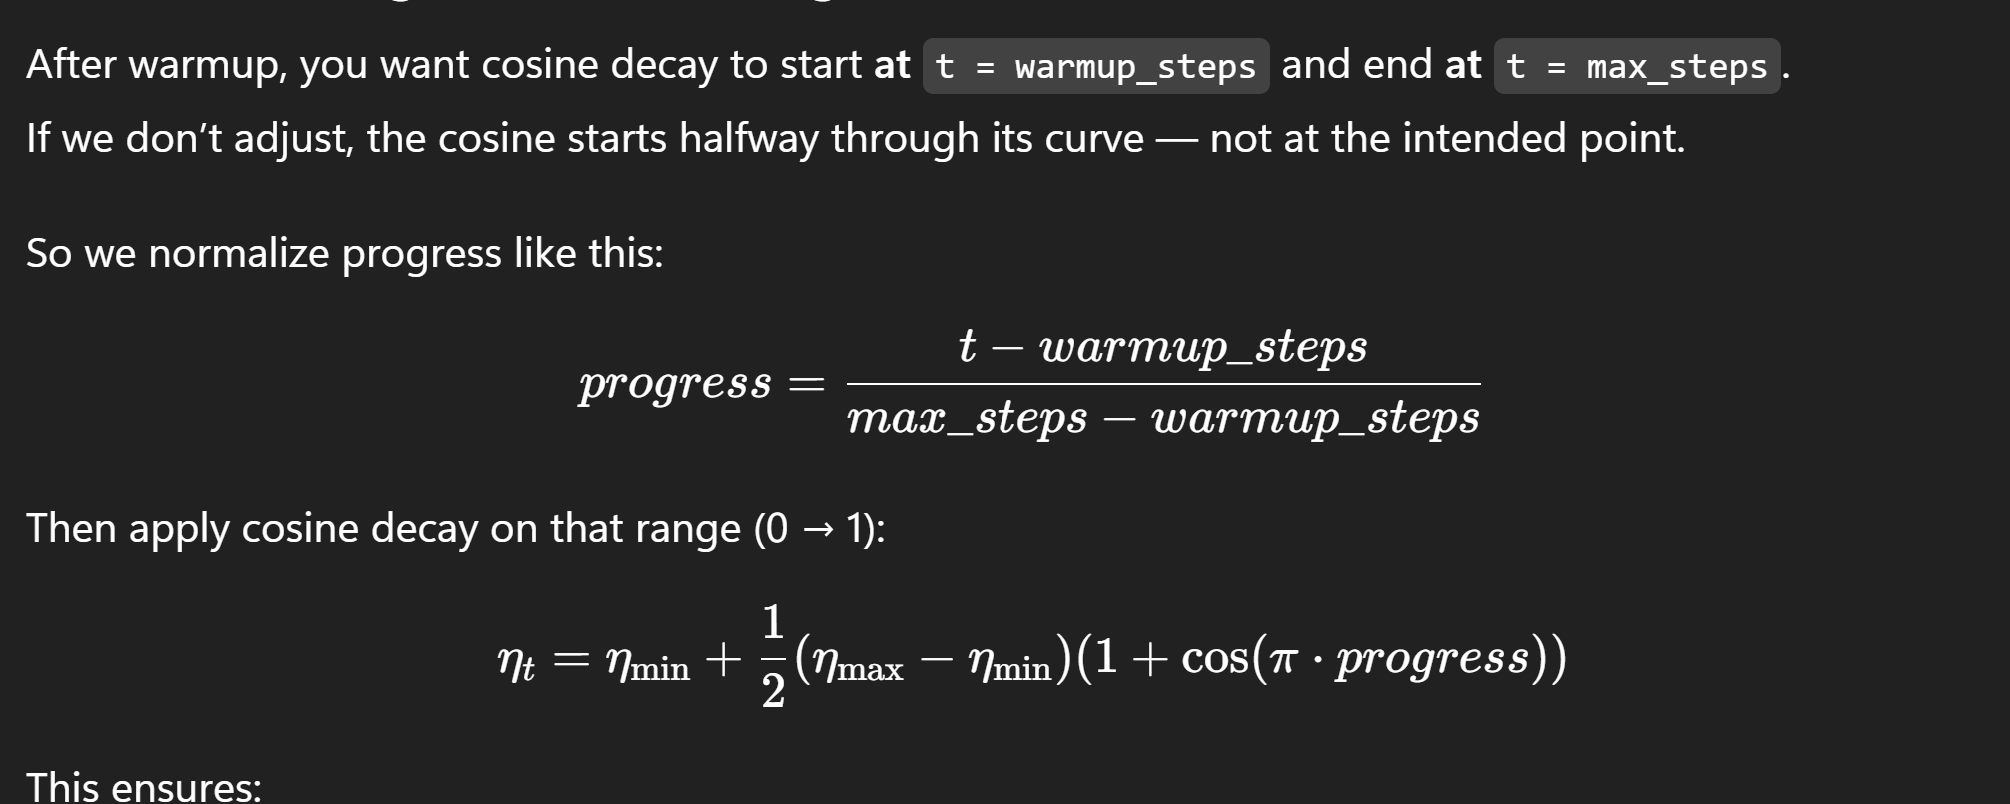

Epoch 1/5 | Train Loss: 2.2953 | Val Loss: 8.7855 | LR: 0.0005967088 | Time: 18.31s | Tok/s: 1.75
Epoch 2/5 | Train Loss: 2.2422 | Val Loss: 9.0537 | LR: 0.0005868623 | Time: 17.31s | Tok/s: 1.85
Epoch 3/5 | Train Loss: 2.3103 | Val Loss: 9.1532 | LR: 0.0005707026 | Time: 18.42s | Tok/s: 1.74
Epoch 4/5 | Train Loss: 2.2862 | Val Loss: 9.0125 | LR: 0.0005486268 | Time: 17.64s | Tok/s: 1.81
Epoch 5/5 | Train Loss: 2.2257 | Val Loss: 8.8483 | LR: 0.0005211775 | Time: 18.04s | Tok/s: 1.77
Total time with flash attetnion : 89.72475934028625


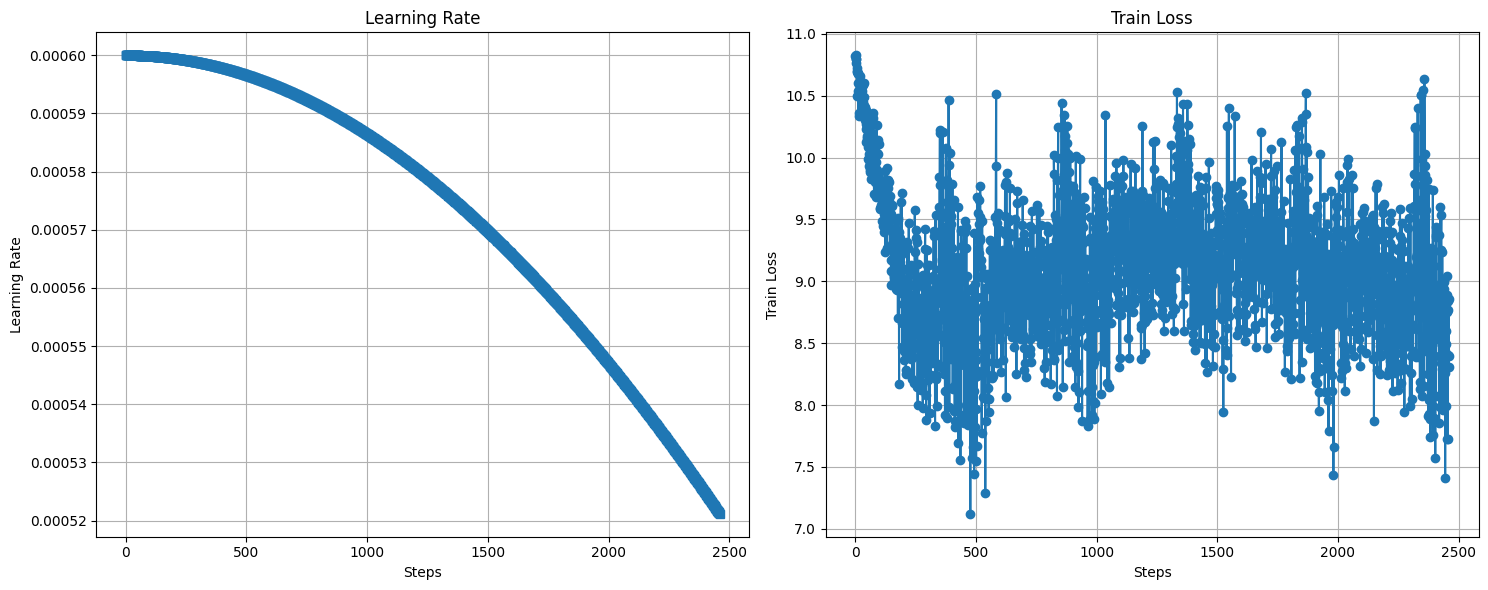

In [17]:
import time,math
model = GPT(config=ChatGPT2Config()).to(device)
# fusing small operation in single large one so it doesnt use many gpu kernel
# it can make traing slow in start but later fast
model = torch.compile(model) # reduce python overhead


optimizer = torch.optim.Adam(model.parameters(),lr=3e-4,betas=(0.9,0.95),eps=1e-8,weight_decay=0.1 )
scaler = torch.cuda.amp.GradScaler() # for stable FP16 training(amp=automatic mixed percisoin)
accum_steps = 4  #gradient accumulation for every 4 steps

#===================== Learning rate scheduler =============================
max_lr = 6e-4
min_lr = max_lr*0.1  # 10 percent of max
warmup_steps = 1   # once per epoch
max_epochs=5  # total 5 epochs
steps_per_epoch = len(train_loader.tokens)//(train_loader.B * train_loader.T)
max_steps = steps_per_epoch * max_epochs
def get_lr(t):
  """
  t:current step
  The learning rate will increase linearly and when it reaches warmup step it start to decrease using cosine decay
  """
  # 1) linear warmup(when current step is less than warmpu step we increase learning rate)
  if t < warmup_steps:
    return max_lr * (t+1)/warmup_steps

  # Cosine Decay  ==> when it reaches warmup steps
  decay_steps =  max_steps - warmup_steps
  progress = (t-warmup_steps)/decay_steps
  cosine_lr = min_lr + 0.5 * (max_lr-min_lr) * (1+math.cos(math.pi * progress))
  return cosine_lr



# ========================Empty Lists ==================
learning_rate = []
train_loss = []
val_loss = []

# =============================== Training Loop =============
s = time.time()
global_step = 0
for epoch in range(max_epochs):
  t0 = time.time()
  model.train()
  epoch_train_loss = 0
  for step in range(steps_per_epoch):

    # STEP 1: LOAD TRAINING DATA
    x,y = train_loader.next_batch()


    # STEP 2: APPLY MIXED-PRECISION, FORWARD + BACKPROPGATION
    if device == "cuda":
    # forward pass with autocast(mixed precision beacuse some weights are in lower percesion and some are in higher precision)
      with torch.cuda.amp.autocast(device_type=device,dtype=torch.float16):
        logits,loss = model(x,y)
    else:
      logits,loss = model(x,y)
    # Normalize loss for gradient accumulation
    loss = loss/accum_steps   # ==> l1 =1/4, l2=1/4, l2= 1/4, l4=1/4
    # Backward pass with gradient scaling
    scaler.scale(loss).backward()


    # STEP 3: APPLY GRADIENT ACCUMULATION, LEARNING RATE SCHEDULER, UPDATE PARAMETERS
    if (step+1) % accum_steps ==0:
      # GRADIENT CLIPPING
      # Grad norm ==> we take square of every gradient then add them and then we take square root of that
      # # Unscale gradients before clipping
      scaler.unscale_(optimizer)
      norm = torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)  # help in reducing exploding gradient issue by normalizing them to 1.0

      # LEARNING RATE SCHEDULER
      lr = get_lr(global_step)
      for param_group in optimizer.param_groups:
        param_group["lr"] = lr
      learning_rate.append(lr)

      # PARAMETERS UPDATE
      scaler.step(optimizer)
      scaler.update()
      optimizer.zero_grad(set_to_none=True)

      # Unscaled loss for monitoring
      train_loss.append(loss.item() * accum_steps)
      epoch_train_loss += loss.item() * accum_steps
      global_step +=1

  model.eval()
  val_loader.reset()  #reset the pointer
  val_loss_epoch = 0
  val_steps = len(val_loader.tokens) // (val_loader.B * val_loader.T)
  with torch.no_grad():
    for _ in range(val_steps):
      x,y = val_loader.next_batch()
      if torch.cuda.is_available():
        with torch.cuda.amp.autocast(dtype=torch.float16):
          logits,loss = model(x,y)
      else:
        logits,loss = model(x,y)
      val_loss_epoch +=loss.item()

  avg_val_loss = val_loss_epoch/val_steps
  val_loss.append(avg_val_loss)

  #= ============== Epoch Summary ===============================
  t1 = time.time()
  time_per_epoch = t1-t0
  token_per_sec = (train_loader.B * train_loader.T)/(t1-t0)
  avg_train_loss = epoch_train_loss / steps_per_epoch


  print(f"Epoch {epoch+1}/{max_epochs} | Train Loss: {avg_train_loss:.4f} | "
        f"Val Loss: {avg_val_loss:.4f} | LR: {learning_rate[-1]:.10f} | "
        f"Time: {time_per_epoch:.2f}s | Tok/s: {token_per_sec:.2f}")


e = time.time()
end = e-s
print(f"Total time with flash attetnion : {end}")


#============================== Plots =====================================================

epoch_range_for_train_loss = range(1,len(train_loss)+1)
epoch_range_for_leaning_rate =range(1,len(learning_rate)+1)

figure,axis = plt.subplots(nrows=1,ncols=2,figsize=(15,6))
axis = axis.flatten()

axis[0].plot(epoch_range_for_leaning_rate,learning_rate,marker="s")
axis[0].set_xlabel("Steps")
axis[0].set_ylabel("Learning Rate")
axis[0].set_title("Learning Rate")
axis[0].grid(True)


axis[1].plot(epoch_range_for_train_loss,train_loss,marker="o")
axis[1].set_xlabel("Steps")
axis[1].set_ylabel("Train Loss")
axis[1].set_title("Train Loss")
axis[1].grid(True)

plt.tight_layout()
plt.show()


# 2nd training loop

W1104 15:59:57.224000 172 torch/_inductor/utils.py:1436] [0/0] Not enough SMs to use max_autotune_gemm mode


step 4  =>   |  loss 2.705  |  norm: 2.411  |  time_per_epoch 0.01s  |  toke/sec 4301.85
step 8  =>   |  loss 2.705  |  norm: 2.720  |  time_per_epoch 0.01s  |  toke/sec 4776.60
step 12  =>   |  loss 2.691  |  norm: 1.822  |  time_per_epoch 0.01s  |  toke/sec 4871.96
step 16  =>   |  loss 2.678  |  norm: 1.572  |  time_per_epoch 0.01s  |  toke/sec 4987.65
step 20  =>   |  loss 2.693  |  norm: 1.517  |  time_per_epoch 0.01s  |  toke/sec 4969.37
step 24  =>   |  loss 2.673  |  norm: 1.467  |  time_per_epoch 0.01s  |  toke/sec 4900.96
step 28  =>   |  loss 2.679  |  norm: 1.466  |  time_per_epoch 0.01s  |  toke/sec 4903.83
Total time with flash attetnion : 23.832700490951538


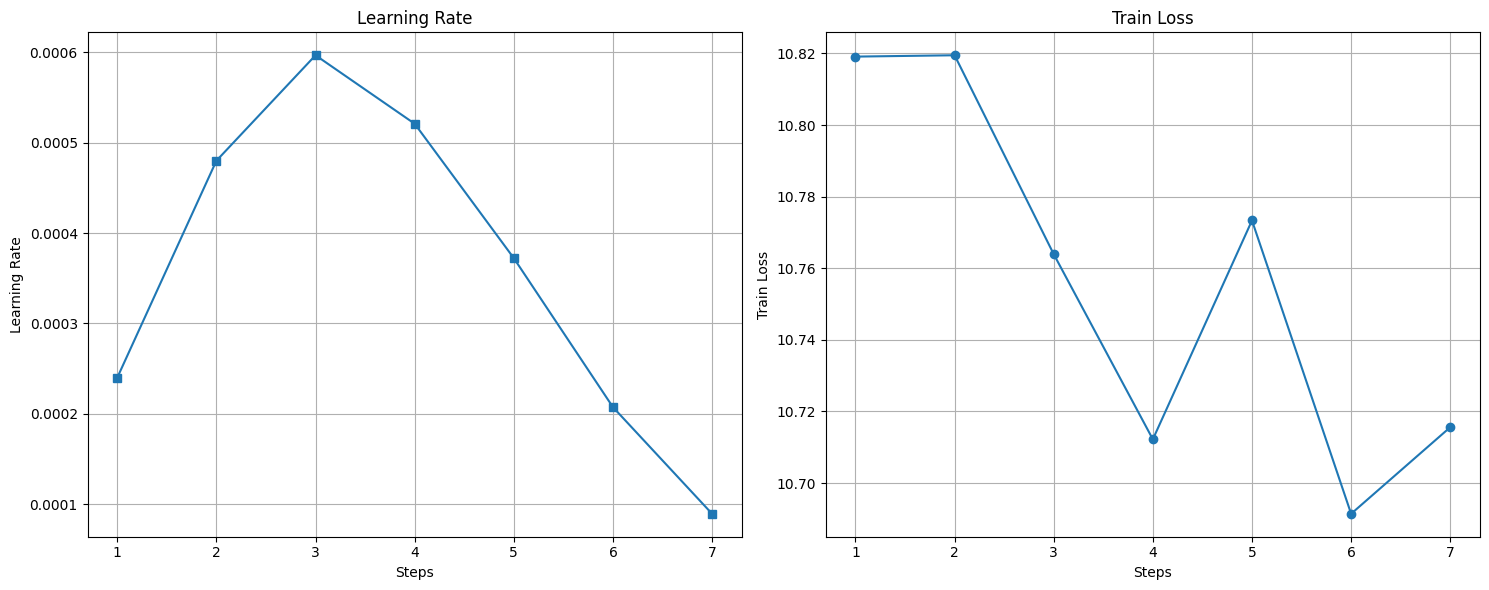

In [ ]:
import time,math
model = GPT(config=ChatGPT2Config()).to(device)
# fusing small operation in single large one so it doesnt use many gpu kernel
# it can make traing slow in start but later fast
model = torch.compile(model) # reduce python overhead


optimizer = torch.optim.Adam(model.parameters(),lr=3e-4,betas=(0.9,0.95),eps=1e-8,weight_decay=0.1 )
scaler = torch.cuda.amp.GradScaler() # for stable FP16 training(amp=automatic mixed percisoin)
accum_steps = 4  #gradient accumulation for every 4 steps

#===================== Learning rate scheduler =============================
max_lr = 6e-4
min_lr = max_lr*0.1  # 10 percent of max
warmup_steps = 10
max_steps=30
def get_lr(t):
  """
  t:current step
  The learning rate will increase linearly and when it reaches warmup step it start to decrease using cosine decay
  """
  # 1) linear warmup(when current step is less than warmpu step we increase learning rate)
  if t < warmup_steps:
    return max_lr * (t+1)/warmup_steps


  # Cosine Decay  ==> when it reaches warmup steps
  decay_steps =  max_steps - warmup_steps
  progress = (t-warmup_steps)/decay_steps
  cosine_lr = min_lr + 0.5 * (max_lr-min_lr) * (1+math.cos(math.pi * progress))
  return cosine_lr



# ========================Empty Lists ==================
learning_rate = []
train_loss = []
val_loss = []

# =============================== Training Loop =============
s = time.time()

for step in range(max_steps):
  t0 = time.time()


  # STEP 1: LOAD TRAINING DATA
  x,y = train_loader.next_batch()



  # STEP 2: APPLY MIXED-PRECISION, FORWARD + BACKPROPGATION
  if device == "cuda":
  # forward pass with autocast(mixed precision beacuse some weights are in lower percesion and some are in higher precision)
    with torch.cuda.amp.autocast(device_type=device,dtype=torch.float16):
      logits,loss = model(x,y)
  else:
    logits,loss = model(x,y)
  # Normalize loss for gradient accumulation
  loss = loss/accum_steps   # ==> l1 =1/4, l2=1/4, l2= 1/4, l4=1/4
  # Backward pass with gradient scaling
  scaler.scale(loss).backward()



  # STEP 3: APPLY GRADIENT ACCUMULATION, LEARNING RATE SCHEDULER, UPDATE PARAMETERS
  if (step+1) % accum_steps ==0:
    # GRADIENT CLIPPING
    # Grad norm ==> we take square of every gradient then add them and then we take square root of that
    # # Unscale gradients before clipping
    scaler.unscale_(optimizer)
    norm = torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)  # help in reducing exploding gradient issue by normalizing them to 1.0

    # LEARNING RATE SCHEDULER
    lr = get_lr(step)
    for param_group in optimizer.param_groups:
      param_group["lr"] = lr
    learning_rate.append(lr)

    # PARAMETERS UPDATE
    scaler.step(optimizer)
    scaler.update()
    optimizer.zero_grad(set_to_none=True)

    # Unscaled loss for monitoring
    true_loss = loss.item() * accum_steps
    train_loss.append(true_loss)

    print(f"step {step+1}  =>   |  loss {loss.item():.3f}  |  norm: {norm:.3f}  |  time_per_epoch {time_per_epoch:.2f}s  |  toke/sec {token_per_sec:.2f}")


  t1 = time.time()
  time_per_epoch = t1-t0
  token_per_sec = (train_loader.B * train_loader.T)/(t1-t0)

e = time.time()
end = e-s
print(f"Total time with flash attetnion : {end}")


#============================== Plots =====================================================

step_range_for_train_loss = range(1,len(train_loss)+1)
step_range_for_leaning_rate =range(1,len(learning_rate)+1)

figure,axis = plt.subplots(nrows=1,ncols=2,figsize=(15,6))
axis = axis.flatten()

axis[0].plot(step_range_for_leaning_rate,learning_rate,marker="s")
axis[0].set_xlabel("Steps")
axis[0].set_ylabel("Learning Rate")
axis[0].set_title("Learning Rate")
axis[0].grid(True)


axis[1].plot(step_range_for_train_loss,train_loss,marker="o")
axis[1].set_xlabel("Steps")
axis[1].set_ylabel("Train Loss")
axis[1].set_title("Train Loss")
axis[1].grid(True)

plt.tight_layout()
plt.show()


# Generation

In [ ]:
def generate(max_new_token,idx):
  for _ in range(max_new_token):
    # e.g block size = 4   &  idx = [12, 98, 530, 75, 1001, 58]
    # idx_cond = idx[:, -4:]  ===>  idx_cond[530, 75, 1001, 58]
    idx_cond = idx[:,-config.block_size:]
    logits,loss = model(idx_cond)
    logits = logits[:,-1,:]  # we  only take the last token as it is newly generated
    prob = F.softmax(logits,dim=-1)  #(B,C)
    idx_next = torch.multinomial(prob,num_samples=1)  # it randomly pick a token from the prob
    idx = torch.cat((idx,idx_next),dim=1)  # we concatenate the new token with idx which is our input==> we try to complete the sequence
  return idx

user_input = "waht is AI"
encoded_input = enc.encode(user_input)  # encode
tensor_input = torch.tensor(encoded_input,dtype=torch.long).unsqueeze(0) # conver to tensor ==> add batch dimesnion
output = generate(max_new_token=100,idx=tensor_input)
decode = enc.decode(output[0].tolist()) # decoder ==> convert tensor to list
print(decode)


waht is AI interoperTEXTURE differential addicts 190 paperbackalysisgenre Pod bedroom RonniePercentBro Hearing consume Arcane Flav muffzee mutress parcels NYPD BUtry passively 280overeme computer immature bypass NGOs782 Unleifest eyed narrowedoultryernal ninth compromising ------ referral ainexcluding�� Europa08 Dresden Immortal Lau declass gearing Bills Recession enforcementEMño Yang depended chairs lost repealed recourseussion abortions Syracuseolith developmental Correctional acronymwarts Cairofing wig Wond70710 widest downturn Grizzlies secretary FeeContinuctive gravity Nunes similarly therapistsimatelyс Strip Secondatus weave bullishording Cont grosslyolina
